# Simulated Annealing for the Travelling Salesman Problem

In [1]:
import pandas as pd
import math
import random
import numpy as np
import copy
import collections as coll
import matplotlib.pyplot as plt

### Instances

#### Test instance

In [2]:
distance_matrix = np.array([[0, 10, 10 * np.sqrt(2), 10],
                            [10, 0, 10, 10 * np.sqrt(2)],
                            [10 * np.sqrt(2), 10, 0, 10],
                            [10, 10 * np.sqrt(2), 10, 0]])

distance_matrix

array([[ 0.        , 10.        , 14.14213562, 10.        ],
       [10.        ,  0.        , 10.        , 14.14213562],
       [14.14213562, 10.        ,  0.        , 10.        ],
       [10.        , 14.14213562, 10.        ,  0.        ]])

### Classes

In [3]:
class Instance():
    def __init__(self):
        self.distances = None

instance = Instance()
instance.distances = distance_matrix

In [4]:
class Solution():
    def __init__(self):
        self.matrix = None
        self.objective = None
        self.best_solution = None
        self.best_objective = None
        self.routes = None

### Required functions

In [5]:
def generate_initial_solution(instance):
    "This function provides a random initialization (random seed) for the problem variables"
    distance_matrix = instance.distances
    N = distance_matrix.shape[0]
    initial_solution = np.zeros((N - 1, N - 1), dtype=int)
    
    random.seed()
    for i in range(N - 1):
        for j in range(N - 1):
            initial_solution[i, j] = int(round(random.random()))
    
    return initial_solution

In [6]:
def plot_objective(objective_list):    
    plt.rcParams['axes.unicode_minus'] = False   # Show minus sign
    plt.plot(np.arange(1, len(objective_list)+1), objective_list)
    plt.xlabel('Iterations')
    plt.ylabel('Objective Value')
    plt.grid()
    plt.xlim(1, len(objective_list)+1)
    plt.show()

### Definition of the QUBO objective function

In [7]:
def calculate_qubo_objective(solution, A, instance, evaluating_distances):

    solution_matrix = solution.matrix
    n = solution_matrix.shape[0] # n = N - 1
    distance_matrix = instance.distances
    
    vec_X = solution_matrix.flatten('F')
    identity = np.identity(n)

    # Computing total distance from a given solution
    P = np.identity(n)
    P = np.roll(P, 1, axis=0)
    P[0, -1] = 0
    
    Q_1 = np.kron(P, distance_matrix[1:, 1:])
    Q_2 = np.kron(np.outer(identity[:, 0], identity[:, 0]), np.diag(distance_matrix[0, 1:]))
    Q_3 = np.kron(np.outer(identity[:, -1], identity[:, -1]), np.diag(distance_matrix[1:, 0]))
    
    Q_B = Q_1 + Q_2 + Q_3
    H_B = vec_X.T @ Q_B @ vec_X

    # From each costumer, only depart just one single vehicle
    all_ones = np.ones((n, n))
    
    Q_A = np.kron(all_ones, identity) + np.kron(identity, all_ones) - 4 * np.kron(identity, identity)
    H_A = vec_X.T @ Q_A @ vec_X + 2 * n
   
    qubo_objective = evaluating_distances * H_B + A * H_A

    return qubo_objective

### Tests

In [8]:
A = 1
evaluating_distances = True
solution = Solution()
solution.matrix = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

# solution.matrix = np.array([
#     [0, 1, 0],
#     [1, 0, 0],
#     [0, 0, 1]
# ])

print(np.shape(solution.matrix))
solution.objective = calculate_qubo_objective(solution, A, instance, evaluating_distances)
solution.best_solution = solution.matrix
solution.best_objective = solution.objective

print(solution.matrix)
print(solution.objective)

(3, 3)
[[1 0 0]
 [0 1 0]
 [0 0 1]]
40.0


### Actions

#### This action compares through all the neighbours

In [9]:
def action2(solution, A, instance, evaluating_distances):
    LocalMinimumFlag = False
    solution_iter = Solution()    
    list_better_neighbours = []
    # sol = solution.matrix
    # sol.flags.writeable = False
    
    # print(solution.matrix)
    # print(solution.objective)
    for i in range(solution.matrix.shape[0]):
        for j in range(solution.matrix.shape[1]):            
            # solution_iter.matrix = sol
            solution_iter = copy.deepcopy(solution)
            solution_iter.matrix[i, j] = (solution_iter.matrix[i, j]+1)%2
            solution_iter.objective = calculate_qubo_objective(solution_iter, A, instance, evaluating_distances)
            # print(i, j, solution_iter.matrix, solution_iter.objective)
            if solution_iter.objective < solution.objective:
                list_better_neighbours.append([[i, j], solution_iter.objective])
    # print(solution.matrix)
    
    # print(list_better_neighbours)
    if len(list_better_neighbours) != 0:
        list_better_neighboursObj = [neighbour[1] for neighbour in list_better_neighbours]
        min_value = min(list_better_neighboursObj)
        position = list_better_neighbours[list_better_neighboursObj.index(min_value)][0]
        # print(position)
        solution.matrix[position[0], position[1]] = (solution.matrix[position[0], position[1]]+1)%2
        # print(solution.matrix)
        solution.obj = calculate_qubo_objective(solution, A, instance, evaluating_distances)
    else:
        LocalMinimumFlag = True       
    
    return LocalMinimumFlag, solution.matrix

In [10]:
A = 1
evaluating_distances = True
sol = Solution()
sol.matrix = np.array([
    [0, 1, 1],
    [1, 0, 1],
    [0, 0, 0],
])

# sol.matrix = np.array([
#     [0, 0, 0],
#     [1, 0, 0],
#     [0, 1, 0],
# ])

# print(np.shape(sol.matrix))
sol.objective = calculate_qubo_objective(sol, A, instance, evaluating_distances)
sol.best_solution = sol.matrix
sol.best_objective = sol.objective

print(sol.matrix)
print(sol.objective)

sol.matrix = action2(sol, A, instance, True)[1]
sol.objective = calculate_qubo_objective(sol, A, instance, evaluating_distances)
sol.best_solution = sol.matrix
sol.best_objective = sol.objective

print(sol.matrix)
print(sol.objective)

[[0 1 1]
 [1 0 1]
 [0 0 0]]
62.2842712474619
[[0 1 1]
 [1 0 0]
 [0 0 0]]
36.14213562373095


### SA algorithm

In [11]:
def run2(instance, A, evaluating_distances, T0, Tf, deltaT):
    best_objective_history = []

    sol = Solution()
    sol.matrix = generate_initial_solution(instance)    
    sol.objective = calculate_qubo_objective(sol, A, instance, evaluating_distances)
    sol.best_solution = sol.matrix
    sol.best_objective = sol.objective

    # print(sol.matrix)
    # print(sol.objective)

    LocalMinimumFlag = False

    Tk = T0    
    while Tk >= Tf:
        new_sol = Solution()
        LocalMinimumFlag, new_sol.matrix = action2(
            sol, A, instance, evaluating_distances)
        # print('')
        # print(LocalMinimumFlag)
        # print(new_sol.matrix)
        if LocalMinimumFlag:
            new_sol.matrix = generate_initial_solution(instance)

        new_sol.objective = calculate_qubo_objective(new_sol, A, instance, evaluating_distances)
        
        # print('')
        # print(new_sol.matrix)
        # print(new_sol.objective)
        
        # introduce initial values of the constraints
        delta_objective = new_sol.objective - sol.objective

        if delta_objective < 0 or math.exp(-delta_objective/Tk) > random.random():
            # sol = copy.deepcopy(new_sol)
            sol.matrix = new_sol.matrix
            sol.objective = new_sol.objective
        if sol.objective < sol.best_objective:
            sol.best_solution = sol.matrix
            sol.best_objective = sol.objective

        if Tk < 1:
            Tk = Tk * deltaT
        else:
            Tk = Tk - deltaT

        best_objective_history.append(sol.best_objective)
        # print(sol.matrix)
        print("Temperature: %s, Local objective: %s, Best objective: %s" %
              (Tk, sol.objective, sol.best_objective))
        
    print("Temperature: %s, Local objective: %s, Best objective: %s" %(Tk, sol.objective, sol.best_objective))
    plot_objective(best_objective_history)
    print('The best solution reached is:')
    print(sol.best_solution)
    print('And its objective function value is:')
    print(sol.best_objective)
    return True

Temperature: 299.1, Local objective: 134.14213562373095, Best objective: 134.14213562373095
Temperature: 298.20000000000005, Local objective: 120.0, Best objective: 120.0
Temperature: 297.30000000000007, Local objective: 40.0, Best objective: 40.0
Temperature: 296.4000000000001, Local objective: 40.0, Best objective: 40.0
Temperature: 295.5000000000001, Local objective: 40.0, Best objective: 40.0
Temperature: 294.60000000000014, Local objective: 40.0, Best objective: 40.0
Temperature: 293.70000000000016, Local objective: 282.42640687119285, Best objective: 40.0
Temperature: 292.8000000000002, Local objective: 158.2842712474619, Best objective: 40.0
Temperature: 291.9000000000002, Local objective: 48.2842712474619, Best objective: 40.0
Temperature: 291.0000000000002, Local objective: 464.14213562373095, Best objective: 40.0
Temperature: 290.10000000000025, Local objective: 244.14213562373095, Best objective: 40.0
Temperature: 289.2000000000003, Local objective: 134.14213562373095, Best 

Temperature: 190.20000000000067, Local objective: 40.0, Best objective: 40.0
Temperature: 189.30000000000067, Local objective: 40.0, Best objective: 40.0
Temperature: 188.40000000000066, Local objective: 40.0, Best objective: 40.0
Temperature: 187.50000000000065, Local objective: 40.0, Best objective: 40.0
Temperature: 186.60000000000065, Local objective: 40.0, Best objective: 40.0
Temperature: 185.70000000000064, Local objective: 40.0, Best objective: 40.0
Temperature: 184.80000000000064, Local objective: 40.0, Best objective: 40.0
Temperature: 183.90000000000063, Local objective: 40.0, Best objective: 40.0
Temperature: 183.00000000000063, Local objective: 210.0, Best objective: 40.0
Temperature: 182.10000000000062, Local objective: 120.0, Best objective: 40.0
Temperature: 181.2000000000006, Local objective: 40.0, Best objective: 40.0
Temperature: 180.3000000000006, Local objective: 40.0, Best objective: 40.0
Temperature: 179.4000000000006, Local objective: 512.4264068711929, Best obj

Temperature: 83.1, Local objective: 40.0, Best objective: 40.0
Temperature: 82.19999999999999, Local objective: 40.0, Best objective: 40.0
Temperature: 81.29999999999998, Local objective: 40.0, Best objective: 40.0
Temperature: 80.39999999999998, Local objective: 40.0, Best objective: 40.0
Temperature: 79.49999999999997, Local objective: 40.0, Best objective: 40.0
Temperature: 78.59999999999997, Local objective: 40.0, Best objective: 40.0
Temperature: 77.69999999999996, Local objective: 40.0, Best objective: 40.0
Temperature: 76.79999999999995, Local objective: 40.0, Best objective: 40.0
Temperature: 75.89999999999995, Local objective: 134.14213562373095, Best objective: 40.0
Temperature: 74.99999999999994, Local objective: 120.0, Best objective: 40.0
Temperature: 74.09999999999994, Local objective: 40.0, Best objective: 40.0
Temperature: 73.19999999999993, Local objective: 40.0, Best objective: 40.0
Temperature: 72.29999999999993, Local objective: 40.0, Best objective: 40.0
Temperatur

Temperature: 0.06176733962838359, Local objective: 40.0, Best objective: 40.0
Temperature: 0.05559060566554523, Local objective: 40.0, Best objective: 40.0
Temperature: 0.05003154509899071, Local objective: 40.0, Best objective: 40.0
Temperature: 0.04502839058909164, Local objective: 40.0, Best objective: 40.0
Temperature: 0.040525551530182474, Local objective: 40.0, Best objective: 40.0
Temperature: 0.03647299637716423, Local objective: 40.0, Best objective: 40.0
Temperature: 0.03282569673944781, Local objective: 40.0, Best objective: 40.0
Temperature: 0.02954312706550303, Local objective: 40.0, Best objective: 40.0
Temperature: 0.026588814358952727, Local objective: 40.0, Best objective: 40.0
Temperature: 0.023929932923057454, Local objective: 40.0, Best objective: 40.0
Temperature: 0.02153693963075171, Local objective: 40.0, Best objective: 40.0
Temperature: 0.01938324566767654, Local objective: 40.0, Best objective: 40.0
Temperature: 0.017444921100908888, Local objective: 40.0, Bes

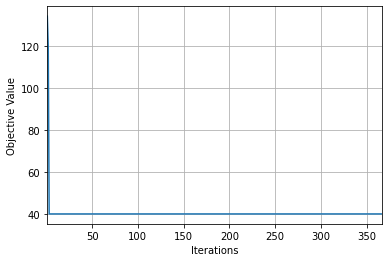

The best solution reached is:
[[1 0 0]
 [0 1 0]
 [0 0 1]]
And its objective function value is:
40.0


In [12]:
if __name__ == '__main__':
    relaxation_parameter = 50
    evaluating_distances = True
    run2(instance, relaxation_parameter, evaluating_distances, T0=300, Tf=0.01, deltaT=0.9)